# Info Statsbomb

## 360

## Events

In [1]:
import numpy as np
import pandas as pd
import json

pd.set_option('display.max_columns', None)


In [2]:
df_events = pd.read_json('https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/3788741.json') 
df_360 = pd.read_json('https://raw.githubusercontent.com/statsbomb/open-data/master/data/three-sixty/3788741.json') 

In [ ]:
def clean_event_data(df_events):
    df_events['type'] = pd.json_normalize(df_events["type"], sep="_")['name'] #type
    df_events['possession_team'] = pd.json_normalize(df_events["possession_team"], sep="_")['name'] #possession
    df_events['play_pattern'] = pd.json_normalize(df_events["play_pattern"], sep="_")['name'] #play_pattern
    df_events['team'] = pd.json_normalize(df_events["team"], sep="_")['name'] #team
    df_events['formation'] = pd.json_normalize(df_events["tactics"], sep="_")['formation'] #tactics
    df_events['player_name'] = pd.json_normalize(df_events["player"], sep="_")['name']#player
    df_events['player_id'] = pd.json_normalize(df_events["player"], sep="_")['id'] #player
    df_events['player_position'] = pd.json_normalize(df_events["position"], sep="_")['name'] #position
    df_events.loc[:, 'x_loc'] = df_events['location'].map(lambda x: get_from_list(0, x)) #location
    df_events.loc[:, 'y_loc'] = df_events['location'].map(lambda x: get_from_list(1, x)) #location

    list_pass = ['length', 'angle', 'end_location', 'recipient_name', 'height_name', 'body_part_name',
                 'type_name', 'outcome_name', 'cross', 'assisted_shot_id', 'shot_assist', 'goal_assist',
                 'recipient_id', 'recipient_id']
    get_info(df_events=df_events, event_col='pass', info_cols=list_pass) #pass
    
    df_events.loc[:, 'pass_endx_loc'] = df_events['pass_end_location'].map(lambda x: get_from_list(0, x))  #pass
    df_events.loc[:, 'pass_endy_loc'] = df_events['pass_end_location'].map(lambda x: get_from_list(1, x))  #pass

    df_events.loc[:, 'carry_endx_loc'] = pd.json_normalize(df_events["carry"], sep="_")['end_location'].map(lambda x: get_from_list(0, x)) #carry
    df_events.loc[:, 'carry_endy_loc'] = pd.json_normalize(df_events["carry"], sep="_")['end_location'].map(lambda x: get_from_list(1, x)) #carry

    df_events['interception_outcome'] = pd.json_normalize(df_events["interception"], sep="_")['outcome_name'] #interception

    df_events['dribble_outcome'] = pd.json_normalize(df_events["dribble"], sep="_")['outcome_name'] #dribble

    df_events['duel_outcome'] = pd.json_normalize(df_events["duel"], sep="_")['outcome_name'] #duel
    
    list_shot = ['statsbomb_xg', 'end_location', 'technique_name', 'body_part_name', 'type_name',
                 'outcome_name', 'key_pass_id', 'aerial_won', 'one_on_one', 'deflected', 'freeze_frame']
    get_info(df_events=df_events, event_col='shot', info_cols=list_shot) #shot

    df_events.loc[:, 'shot_endx_loc'] = df_events['shot_end_location'].map(lambda x: get_from_list(0, x))  #shot
    df_events.loc[:, 'shot_endy_loc'] = df_events['shot_end_location'].map(lambda x: get_from_list(1, x))  #shot
    df_events.loc[:, 'shot_endz_loc'] = df_events['shot_end_location'].map(lambda x: get_from_list(2, x))  #shot

    df_events['gk_outcome'] = pd.json_normalize(df_events["goalkeeper"], sep="_")['outcome_name']

    
    list_foul_won = ['advantage', 'defensive', 'penalty']
    get_info(df_events=df_events, event_col='foul_won', info_cols=list_foul_won)

    list_foul_committed = ['card_name', 'type_name', 'offensive', 'advantage']
    get_info(df_events=df_events, event_col='foul_committed', info_cols=list_foul_committed)

    df_events['substituition_outcome_name'] = pd.json_normalize(df_events['substitution'], sep="_")['outcome_name']
    df_events['substituition_replacement_name'] = pd.json_normalize(df_events['substitution'], sep="_")['replacement_name']
    
    df_events['endx_loc'] = df_events['pass_endx_loc'].fillna(0) + df_events['shot_endx_loc'].fillna(0) + df_events['carry_endx_loc'].fillna(0)
    df_events['endy_loc'] = df_events['pass_endy_loc'].fillna(0) + df_events['shot_endy_loc'].fillna(0) + df_events['carry_endy_loc'].fillna(0)
    df_events['endz_loc'] = df_events['shot_endz_loc'].fillna(0)
    
    aux_x_loc = df_events['x_loc'].fillna(df_events['endx_loc'].shift(1)).fillna(method='bfill')
    aux_y_loc = df_events['y_loc'].fillna(df_events['endy_loc'].shift(1)).fillna(method='bfill')
    aux_endx_loc = df_events['endx_loc'].fillna(df_events['x_loc'].shift(-1)).fillna(method='bfill')
    aux_endy_loc = df_events['endy_loc'].fillna(df_events['y_loc'].shift(-1)).fillna(method='bfill')
    df_events.loc[:, 'x_loc'] = aux_x_loc
    df_events.loc[:, 'y_loc'] = aux_y_loc
    df_events.loc[:, 'endx_loc'] = aux_endx_loc
    df_events.loc[:, 'endy_loc'] = aux_endy_loc
    
    df_events.loc[(df_events['endx_loc'] == 0) &
                  (df_events['endy_loc'] == 0),
                  ['endx_loc','endy_loc']] = df_events.loc[(df_events['endx_loc'] == 0) &
                                                           (df_events['endy_loc'] == 0),
                                                           ['x_loc','y_loc']].values
    
    df_events.loc[df_events['type'] == "Pass", 'pass_outcome_name'] = df_events.loc[df_events['type'] == "Pass", 'pass_outcome_name'].fillna("Successful")
    
    df_events["outcome_name"] = df_events['pass_outcome_name'].combine_first(
        df_events['interception_outcome']).combine_first(
        df_events['dribble_outcome']).combine_first(
            df_events['duel_outcome']).combine_first(
                df_events['shot_outcome_name']).combine_first(
                    df_events['gk_outcome'])


    
    cols_drop = ['pass_endx_loc', 'pass_endy_loc', 'shot_endx_loc', 'shot_endy_loc', 'shot_endz_loc',
                 'carry_endx_loc', 'carry_endy_loc', 'shot_end_location', 'pass_end_location', 
                'pass_outcome_name', 'interception_outcome', 'dribble_outcome', 'duel_outcome',
                  'shot_outcome_name', 'gk_outcome']

    df_events = df_events.drop(columns=cols_drop)
    
    df_events = merge_player_info(df_events, df_lineup)

    return(df_events)

In [3]:
df = pd.merge(df_events,
              df_360,
              how='inner',
              left_on='id', 
              right_on='event_uuid')

In [4]:
##getting info from json

def get_info(df_events:pd.DataFrame(), event_col, info_cols):
    try:
        df_info = pd.json_normalize(df_events[event_col], sep="_")
        for col in df_info.columns:
            if col in info_cols:
                new_col_name = '_'.join([event_col, col])
                df_events.loc[:, new_col_name] = df_info[col]
            else:
                pass
    except:
        pass

In [13]:
df_type

NameError: name 'df_type' is not defined

In [12]:
    df['type'] = pd.json_normalize(df["type"], sep="_")['name']
    df['possession_team'] = pd.json_normalize(df["possession_team"], sep="_")['name'] #possession
    df['play_pattern'] = pd.json_normalize(df["play_pattern"], sep="_")['name'] #play_pattern
    df['team'] = pd.json_normalize(df["team"], sep="_")['name'] #team
    #df['formation'] = pd.json_normalize(df["tactics"], sep="_")['formation'] #tactics
    #df['player_name'] = pd.json_normalize(df["player"], sep="_")['name']#player
    df['player_id'] = pd.json_normalize(df["player"], sep="_")['id'] #player
    df['player_position'] = pd.json_normalize(df["position"], sep="_")['name'] #position
    df.loc[:, 'x_loc'] = df['location'].map(lambda x: get_from_list(0, x)) #location
    df.loc[:, 'y_loc'] = df['location'].map(lambda x: get_from_list(1, x)) #location


AttributeError: 'str' object has no attribute 'values'

In [7]:
df['event_name'] = pd.json_normalize(df['type'])['name']
df['possession_team_name'] = pd.json_normalize(df['possession_team'])['name']
df = df.drop(columns=['type', 'possession_team'])

In [8]:
df['event_name'].value_counts()

Ball Receipt*       940
Pass                936
Carry               823
Pressure            360
Ball Recovery        85
Duel                 48
Interception         45
Clearance            38
Block                31
Dribble              29
Shot                 26
Foul Committed       21
Foul Won             21
Miscontrol           19
Dribbled Past        18
Goal Keeper          15
Dispossessed         11
Shield                1
Own Goal Against      1
Own Goal For          1
Offside               1
Name: event_name, dtype: int64

In [12]:
df.head(2)

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,goalkeeper,clearance,ball_recovery,foul_committed,foul_won,block,substitution,event_uuid,visible_area,freeze_frame
0,19edeac2-e63f-4795-8a8b-17a6e9fdb6e3,1,1,2022-12-22,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 909, 'name': 'Turkey'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,89072e2e-b64f-4099-846b-b22cf000f9c7,2,1,2022-12-22,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 909, 'name': 'Turkey'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Limpando DataFrame

In [46]:
import numpy as np
import pandas as pd

def merge_player_info(df_type, df_lineup, cols_selected = ['player_id', 'player_nickname', 'jersey_number']):
    df_lineup['player_nickname'] = df_lineup['player_nickname'].fillna(df_lineup['player_name'])
    df_lineup = df_lineup[cols_selected]
    df_aux = df_type.merge(df_lineup, left_on='player_id', right_on='player_id', how='left',)
    df_aux['player_name'] = df_aux['player_nickname']
    
    df_aux = df_aux.drop(columns=['player_nickname'])
    return(df_aux)

def get_info(df_events, event_col, info_cols):
    try:
        df_info = pd.json_normalize(df_events[event_col], sep="_")
        for col in df_info.columns:
            if col in info_cols:
                new_col_name = '_'.join([event_col, col])
                df_events.loc[:, new_col_name] = df_info[col]
            else:
                pass
    except:
        pass


def get_from_list(n, lista):
    if (lista is not np.nan):
        try:
            sublista = lista[n]
            return(sublista)
        except IndexError:
            pass
    else:
        pass
    
def get_starting_team(df_events):
    home_lineup = pd.json_normalize(pd.json_normalize(df_events["tactics"], sep="_")['lineup'][0], sep='_')[['player_id', 'player_name', 'jersey_number', 'position_name']]
    home_lineup['team'] = pd.json_normalize(df_events["team"], sep="_")['name'][0]
    away_lineup = pd.json_normalize(pd.json_normalize(df_events["tactics"], sep="_")['lineup'][1], sep='_')[['player_id', 'player_name', 'jersey_number', 'position_name']]
    away_lineup['team'] = pd.json_normalize(df_events["team"], sep="_")['name'][1]

    df_starting = pd.concat([home_lineup, away_lineup])
    df_starting = df_starting.reset_index(drop=True)
    
    return(df_starting)


def get_lineups(df_players, df_titular):
    home_lineup = pd.json_normalize(df_players["lineup"][0], sep="_")
    away_lineup = pd.json_normalize(df_players["lineup"][1], sep="_")
        
    home_lineup["team_name"] = df_players['team_name'][0]
    away_lineup["team_name"] = df_players['team_name'][1]
    
    home_lineup['home'] = True
    away_lineup['home'] = False
    
    df_lineup = home_lineup.append(away_lineup)
    
    df_titular = df_titular.drop(columns=['player_name', 'jersey_number', 'team'])
    df_lineup = df_lineup.merge(df_titular, how='left', on='player_id')
    
    df_lineup.loc[~df_lineup['position_name'].isna(), 'starting11'] = True
    df_lineup['starting11'] = df_lineup['starting11'].fillna(False)
    df_lineup['position_name'] = df_lineup['position_name'].fillna("Sub")
    
    return(df_lineup)


def clean_event_data(df_events):
    df_events['type'] = pd.json_normalize(df_events["type"], sep="_")['name'] #type
    df_events['possession_team'] = pd.json_normalize(df_events["possession_team"], sep="_")['name'] #possession
    df_events['play_pattern'] = pd.json_normalize(df_events["play_pattern"], sep="_")['name'] #play_pattern
    df_events['team'] = pd.json_normalize(df_events["team"], sep="_")['name'] #team
    df_events['formation'] = pd.json_normalize(df_events["tactics"], sep="_")['formation'] #tactics
    df_events['player_name'] = pd.json_normalize(df_events["player"], sep="_")['name']#player
    df_events['player_id'] = pd.json_normalize(df_events["player"], sep="_")['id'] #player
    df_events['player_position'] = pd.json_normalize(df_events["position"], sep="_")['name'] #position
    df_events.loc[:, 'x_loc'] = df_events['location'].map(lambda x: get_from_list(0, x)) #location
    df_events.loc[:, 'y_loc'] = df_events['location'].map(lambda x: get_from_list(1, x)) #location

    list_pass = ['length', 'angle', 'end_location', 'recipient_name', 'height_name', 'body_part_name',
                 'type_name', 'outcome_name', 'cross', 'assisted_shot_id', 'shot_assist', 'goal_assist',
                 'recipient_id', 'recipient_id']
    get_info(df_events=df_events, event_col='pass', info_cols=list_pass) #pass
    
    df_events.loc[:, 'pass_endx_loc'] = df_events['pass_end_location'].map(lambda x: get_from_list(0, x))  #pass
    df_events.loc[:, 'pass_endy_loc'] = df_events['pass_end_location'].map(lambda x: get_from_list(1, x))  #pass

    df_events.loc[:, 'carry_endx_loc'] = pd.json_normalize(df_events["carry"], sep="_")['end_location'].map(lambda x: get_from_list(0, x)) #carry
    df_events.loc[:, 'carry_endy_loc'] = pd.json_normalize(df_events["carry"], sep="_")['end_location'].map(lambda x: get_from_list(1, x)) #carry

    df_events['interception_outcome'] = pd.json_normalize(df_events["interception"], sep="_")['outcome_name'] #interception

    df_events['dribble_outcome'] = pd.json_normalize(df_events["dribble"], sep="_")['outcome_name'] #dribble

    df_events['duel_outcome'] = pd.json_normalize(df_events["duel"], sep="_")['outcome_name'] #duel
    
    list_shot = ['statsbomb_xg', 'end_location', 'technique_name', 'body_part_name', 'type_name',
                 'outcome_name', 'key_pass_id', 'aerial_won', 'one_on_one', 'deflected', 'freeze_frame']
    get_info(df_events=df_events, event_col='shot', info_cols=list_shot) #shot

    df_events.loc[:, 'shot_endx_loc'] = df_events['shot_end_location'].map(lambda x: get_from_list(0, x))  #shot
    df_events.loc[:, 'shot_endy_loc'] = df_events['shot_end_location'].map(lambda x: get_from_list(1, x))  #shot
    df_events.loc[:, 'shot_endz_loc'] = df_events['shot_end_location'].map(lambda x: get_from_list(2, x))  #shot

    df_events['gk_outcome'] = pd.json_normalize(df_events["goalkeeper"], sep="_")['outcome_name']

    
    list_foul_won = ['advantage', 'defensive', 'penalty']
    get_info(df_events=df_events, event_col='foul_won', info_cols=list_foul_won)

    list_foul_committed = ['card_name', 'type_name', 'offensive', 'advantage']
    get_info(df_events=df_events, event_col='foul_committed', info_cols=list_foul_committed)

    df_events['substituition_outcome_name'] = pd.json_normalize(df_events['substitution'], sep="_")['outcome_name']
    df_events['substituition_replacement_name'] = pd.json_normalize(df_events['substitution'], sep="_")['replacement_name']
    
    df_events['endx_loc'] = df_events['pass_endx_loc'].fillna(0) + df_events['shot_endx_loc'].fillna(0) + df_events['carry_endx_loc'].fillna(0)
    df_events['endy_loc'] = df_events['pass_endy_loc'].fillna(0) + df_events['shot_endy_loc'].fillna(0) + df_events['carry_endy_loc'].fillna(0)
    df_events['endz_loc'] = df_events['shot_endz_loc'].fillna(0)
    
    aux_x_loc = df_events['x_loc'].fillna(df_events['endx_loc'].shift(1)).fillna(method='bfill')
    aux_y_loc = df_events['y_loc'].fillna(df_events['endy_loc'].shift(1)).fillna(method='bfill')
    aux_endx_loc = df_events['endx_loc'].fillna(df_events['x_loc'].shift(-1)).fillna(method='bfill')
    aux_endy_loc = df_events['endy_loc'].fillna(df_events['y_loc'].shift(-1)).fillna(method='bfill')
    df_events.loc[:, 'x_loc'] = aux_x_loc
    df_events.loc[:, 'y_loc'] = aux_y_loc
    df_events.loc[:, 'endx_loc'] = aux_endx_loc
    df_events.loc[:, 'endy_loc'] = aux_endy_loc
    
    df_events.loc[(df_events['endx_loc'] == 0) &
                  (df_events['endy_loc'] == 0),
                  ['endx_loc','endy_loc']] = df_events.loc[(df_events['endx_loc'] == 0) &
                                                           (df_events['endy_loc'] == 0),
                                                           ['x_loc','y_loc']].values
    
    df_events.loc[df_events['type'] == "Pass", 'pass_outcome_name'] = df_events.loc[df_events['type'] == "Pass", 'pass_outcome_name'].fillna("Successful")
    
    df_events["outcome_name"] = df_events['pass_outcome_name'].combine_first(
        df_events['interception_outcome']).combine_first(
        df_events['dribble_outcome']).combine_first(
            df_events['duel_outcome']).combine_first(
                df_events['shot_outcome_name']).combine_first(
                    df_events['gk_outcome'])


    
    cols_drop = ['pass_endx_loc', 'pass_endy_loc', 'shot_endx_loc', 'shot_endy_loc', 'shot_endz_loc',
                 'carry_endx_loc', 'carry_endy_loc', 'shot_end_location', 'pass_end_location', 
                'pass_outcome_name', 'interception_outcome', 'dribble_outcome', 'duel_outcome',
                  'shot_outcome_name', 'gk_outcome']

    df_events = df_events.drop(columns=cols_drop)
    
    #df_events = merge_player_info(df_events, df_lineup)

    return(df_events)

In [47]:
df_players = pd.read_json('https://raw.githubusercontent.com/statsbomb/open-data/master/data/lineups/3788741.json') 

In [48]:
df_events = clean_event_data(df_events=df_events)

AttributeError: 'float' object has no attribute 'items'

## criando rede de passes

In [13]:
def create_passes_network_table(df_events, 
                                team_name,
                                fst_half=True,
                                scnd_half=True,
                                min_passes=5):
    df_aux = create_passes_table(df_events, player_name=None, team_name=team_name, player_id=None, success_only=True, fst_half=fst_half, scnd_half=scnd_half)
    
    replace_id = df_aux.loc[:, ['player_id',
                                'jersey_number']].drop_duplicates().dropna().set_index('player_id',
                                                                                                    drop=True).to_dict()['jersey_number']
    
    df_aux.loc[:, ['player_id', 'pass_recipient_id']] = df_aux.loc[:, ['player_id', 'pass_recipient_id']].replace(replace_id)
    df_successful = df_aux.loc[df_aux["outcome_name"]=="Successful", :]

    pas = pd.to_numeric(df_successful['player_id'], downcast='integer')
    rec = pd.to_numeric(df_successful['pass_recipient_id'], downcast='integer')
    df_successful.loc[:, 'player_id'] = pas
    df_successful.loc[:, 'pass_recipient_id'] = rec
    
    df_avg_locations = df_successful.groupby(by='player_id').agg({'x_loc': ['mean'],
                                                            'y_loc': ['mean', 'count']}, )
    df_avg_locations.columns = ['x_loc', 'y_loc', 'count']
    
    df_pass_between = df_successful.groupby(by=['player_id', 'pass_recipient_id']).id.count().reset_index()
    df_pass_between.rename({"id":'pass_count'}, axis="columns", inplace=True)
    df_pass_between = df_pass_between.merge(df_avg_locations, left_on='player_id', right_index=True)
    df_pass_between = df_pass_between.merge(df_avg_locations, left_on='pass_recipient_id', right_index=True, suffixes=['', '_end'])
    
    
    df_pass_between['player_id'].unique().tolist()

    df_pass_between = df_pass_between[df_pass_between['pass_count']>min_passes]

    df_avg_locations = df_avg_locations.loc[set(df_pass_between['player_id'].unique().tolist() + 
                                                df_pass_between['pass_recipient_id'].unique().tolist()), :]
    
    df_pass_between['team_name'] = team_name
    df_pass_between['against_team'] = df_aux['against_team'].unique()[0]
    
    return(df_avg_locations, df_pass_between)

In [14]:
create_passes_network_table(df, "Turkey", min_passes=1)

KeyError: "['pass_shot_assist', 'x_loc', 'player_id', 'jersey_number', 'endx_loc', 'y_loc', 'outcome_name', 'player_name', 'endy_loc', 'pass_recipient_id'] not in index"

In [38]:
df_shots = df.loc[df['event_name']=='Shot', :]

In [43]:
pd.Series.explode(df_shots['freeze_frame'])

105     {'teammate': True, 'actor': False, 'keeper': F...
105     {'teammate': True, 'actor': False, 'keeper': F...
105     {'teammate': False, 'actor': False, 'keeper': ...
105     {'teammate': False, 'actor': False, 'keeper': ...
105     {'teammate': True, 'actor': True, 'keeper': Fa...
                              ...                        
3764    {'teammate': True, 'actor': False, 'keeper': F...
3764    {'teammate': True, 'actor': False, 'keeper': F...
3764    {'teammate': False, 'actor': False, 'keeper': ...
3764    {'teammate': False, 'actor': False, 'keeper': ...
3764    {'teammate': False, 'actor': False, 'keeper': ...
Name: freeze_frame, Length: 361, dtype: object

In [25]:
df_events.loc[df_events['id'] == '5c210f79-9714-44a6-b2ec-387f6a117b37',
              'type']

7    {'id': 30, 'name': 'Pass'}
Name: type, dtype: object

In [26]:
frames.loc[48:55]

,teammate,actor,keeper,match_id,id,x,y
48,False,False,False,3788741,605315c0-8960-4f53-94cb-87ae77e86750,71.488884,65.552810
49,False,False,False,3788741,605315c0-8960-4f53-94cb-87ae77e86750,74.633095,47.966007
50,True,False,False,3788741,5c210f79-9714-44a6-b2ec-387f6a117b37,26.729105,53.791424
51,True,True,False,3788741,5c210f79-9714-44a6-b2ec-387f6a117b37,35.995540,32.086930
52,False,False,False,3788741,5c210f79-9714-44a6-b2ec-387f6a117b37,38.428318,36.866302
53,True,False,False,3788741,5c210f79-9714-44a6-b2ec-387f6a117b37,38.942722,10.801361
54,True,False,False,3788741,5c210f79-9714-44a6-b2ec-387f6a117b37,41.634647,71.110344
55,True,False,False,3788741,5c210f79-9714-44a6-b2ec-387f6a117b37,44.969180,38.656685


In [46]:
frames.loc[frames.id=='e735a328-2e55-437f-a5d0-5317201855db',:]

,teammate,actor,keeper,match_id,id,x,y
8253,True,False,False,3788741,e735a328-2e55-437f-a5d0-5317201855db,95.554276,51.142822
8254,False,False,False,3788741,e735a328-2e55-437f-a5d0-5317201855db,97.015680,24.528698
8255,True,True,False,3788741,e735a328-2e55-437f-a5d0-5317201855db,97.712470,56.800896
8256,False,False,False,3788741,e735a328-2e55-437f-a5d0-5317201855db,98.060310,41.485157
8257,True,False,False,3788741,e735a328-2e55-437f-a5d0-5317201855db,100.086560,38.383070
8258,False,False,False,3788741,e735a328-2e55-437f-a5d0-5317201855db,100.896180,52.070150
8259,False,False,False,3788741,e735a328-2e55-437f-a5d0-5317201855db,102.254550,57.021744
8260,True,False,False,3788741,e735a328-2e55-437f-a5d0-5317201855db,102.395810,25.819270
8261,False,False,False,3788741,e735a328-2e55-437f-a5d0-5317201855db,105.792200,42.921024
8262,False,False,False,3788741,e735a328-2e55-437f-a5d0-5317201855db,106.374886,29.795030


In [53]:
visible.loc[visible['id']=='e735a328-2e55-437f-a5d0-5317201855db', :]

,match_id,id,visible_area
586,3788741,e735a328-2e55-437f-a5d0-5317201855db,"[93.5596966161573, 80.0, 81.1115551746494, 12...."


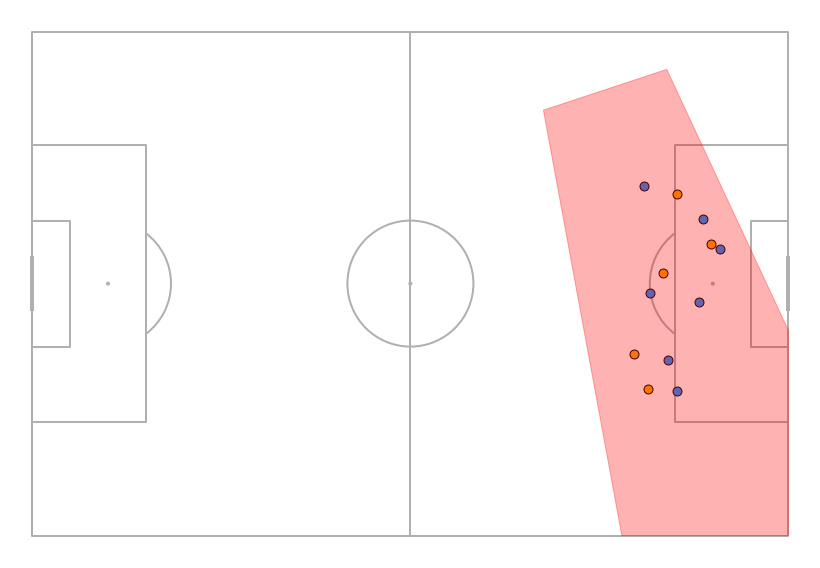

In [55]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen
import numpy as np

## load in Statsbomb360 data remotely
    parser = Sbopen()
frames, visible = parser.frame(3788741)

## get plotting data
frame_idx = 586
frame_id = visible.iloc[586].id

visible_area = np.array(visible.iloc[frame_idx].visible_area).reshape(-1, 2)
player_position_data = frames[frames.id == frame_id]

teammate_locs = player_position_data[player_position_data.teammate]
opponent_locs = player_position_data[~player_position_data.teammate]

## set up pitch
p = Pitch(pitch_type='statsbomb')
fig, ax = p.draw(figsize=(12,8))

p.scatter(teammate_locs.x, teammate_locs.y, c='orange', s=80, ec='k', ax=ax)
p.scatter(opponent_locs.x, opponent_locs.y, c='dodgerblue', s=80, ec='k', ax=ax)
p.polygon([visible_area], color=(1, 0, 0, 0.3), ax=ax)

plt.show() ##to see the plot. You don't need this if you're using a jupyter notebook


In [21]:
frames

,teammate,actor,keeper,match_id,id,x,y
0,False,False,False,3788741,bbc398f7-c784-4958-a504-37b583caf97a,43.722042,31.659489
1,False,False,False,3788741,bbc398f7-c784-4958-a504-37b583caf97a,44.066185,45.270540
2,False,False,False,3788741,bbc398f7-c784-4958-a504-37b583caf97a,49.744540,35.105324
3,False,False,False,3788741,bbc398f7-c784-4958-a504-37b583caf97a,54.562540,29.764278
4,False,False,False,3788741,bbc398f7-c784-4958-a504-37b583caf97a,58.348110,48.199497
...,...,...,...,...,...,...,...
47055,True,False,False,3788741,1aad65b5-8dbd-4901-bdef-8362ca7ea498,108.898300,43.917570
47056,False,False,False,3788741,1aad65b5-8dbd-4901-bdef-8362ca7ea498,109.152950,10.814496
47057,False,False,False,3788741,1aad65b5-8dbd-4901-bdef-8362ca7ea498,109.652150,39.378212
47058,False,False,False,3788741,1aad65b5-8dbd-4901-bdef-8362ca7ea498,109.734480,29.291084


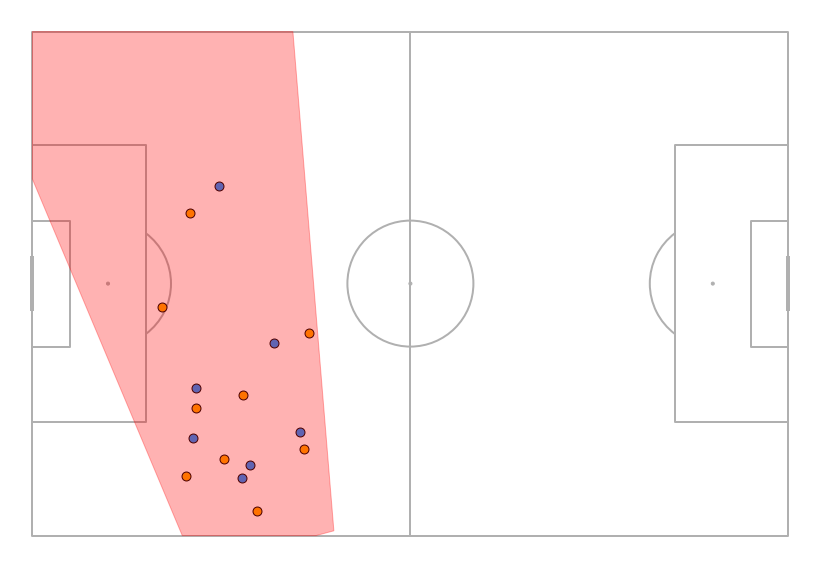

In [20]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen
import numpy as np

## load in Statsbomb360 data remotely
parser = Sbopen()
frames, visible = parser.frame(3788741)

## get plotting data
frame_idx = 49
frame_id = visible.iloc[49].id

visible_area = np.array(visible.iloc[frame_idx].visible_area).reshape(-1, 2)
player_position_data = frames[frames.id == frame_id]

teammate_locs = player_position_data[player_position_data.teammate]
opponent_locs = player_position_data[~player_position_data.teammate]

## set up pitch
p = Pitch(pitch_type='statsbomb')
fig, ax = p.draw(figsize=(12,8))

p.scatter(teammate_locs.x, teammate_locs.y, c='orange', s=80, ec='k', ax=ax)
p.scatter(opponent_locs.x, opponent_locs.y, c='dodgerblue', s=80, ec='k', ax=ax)
p.polygon([visible_area], color=(1, 0, 0, 0.3), ax=ax)

plt.show() ##to see the plot. You don't need this if you're using a jupyter notebook
